Import Libraries

In [86]:
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

In [88]:
def read_file(file_path):
    try:
        meta_data = pd.read_pickle(file_path)
        return meta_data
    except FileNotFoundError:
        print(f'{file_path} does not exist')
        return None

file_path = 'E:\meta_data_balance2.pkl'
meta_data = read_file(file_path)
meta_data.head()

,lesion_id,image_id,diagnosis,diagnosis_method,age,sex,lesion_site,path,Up_Diagnosis,label_encoded
0,HAM_0004098,ISIC_0025843,Melanocytic nevi,follow_up,45,female,trunk,E:\HAM_images_labels\ISIC_0025843.jpg,Melanocytic nevi,4
1,HAM_0002623,ISIC_0025384,Melanocytic nevi,follow_up,45,female,trunk,E:\HAM_images_labels\ISIC_0025384.jpg,Melanocytic nevi,4
2,HAM_0005234,ISIC_0027347,Melanocytic nevi,follow_up,45,female,genital,E:\HAM_images_labels\ISIC_0027347.jpg,Melanocytic nevi,4
3,HAM_0001335,ISIC_0026555,Melanocytic nevi,follow_up,50,male,upper extremity,E:\HAM_images_labels\ISIC_0026555.jpg,Melanocytic nevi,4
4,HAM_0007329,ISIC_0026583,Melanocytic nevi,follow_up,50,male,lower extremity,E:\HAM_images_labels\ISIC_0026583.jpg,Melanocytic nevi,4


In [89]:
X = meta_data.drop(['diagnosis'], axis=1)
Y = meta_data['diagnosis']
X.shape, Y.shape

((10248, 9), (10248,))

Train, Test and Validation

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [91]:
X_train.columns

Index(['lesion_id', 'image_id', 'diagnosis_method', 'age', 'sex',
       'lesion_site', 'path', 'Up_Diagnosis', 'label_encoded'],
      dtype='object')

Image Data Generator

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
)

test_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col = 'path',
    y_col = 'Up_Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=X_val,
    x_col = 'path',
    y_col = 'Up_Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='path',
    y_col='Up_Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6558 validated image filenames belonging to 7 classes.
Found 1640 validated image filenames belonging to 7 classes.
Found 2050 validated image filenames belonging to 7 classes.


In [93]:
len(train_generator), len(test_generator), len(test_generator)

(205, 65, 65)

Resnet Model

In [ ]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, 
                                    GlobalAveragePooling2D, Dense, ReLU, Flatten, AveragePooling2D)
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    # Convolution layer 1 with kernel_initializer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', 
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Convolution layer 2
    x = Conv2D(filters, kernel_size, strides=1, padding='same', 
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same', 
                          kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])    
    x = ReLU()(x)
    return x

In [ ]:
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (7,7), strides=2, padding='same', 
               kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)

    # Residual blocks
    # Block 1
    for _ in range(2):
        x = residual_block(x, 64)
    
    # Block 2
    x = residual_block(x, 128, stride=2)
    for _ in range(1):
        x = residual_block(x, 128)
    
    # Block 3
    x = residual_block(x, 256, stride=2)
    for _ in range(1):
        x = residual_block(x, 256)
    
    # Block 4
    x = residual_block(x, 512, stride=2)
    for _ in range(1):
        x = residual_block(x, 512)

    # Thay Flatten bằng Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Thêm dense layer với regularization
    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [98]:
resnet_model = build_resnet(input_shape=(224, 224, 3), num_classes=7)
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [99]:
resnet_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [100]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
reduce_lr=ReduceLROnPlateau(monitor="val_accuracy",
                           factor=0.5,
                           patience=5,
                           verbose=1,
                           mode="auto", min_lr=1e-5)
tensorboard= TensorBoard(log_dir="logs")

# early_stopping = EarlyStopping(monitor='val_accuracy', 
#                                patience=15, 
#                                restore_best_weights=True, 
#                                min_delta=0.001)

In [101]:
epochs = 75
history = resnet_model.fit(train_generator,
                           validation_data=val_generator,
                           epochs=epochs,
                           verbose=1,
                           callbacks=[reduce_lr, tensorboard])

Epoch 1/75
205/205 [==============================] - 83s 394ms/step - loss: 1.0838 - accuracy: 0.6783 - val_loss: 2.0165 - val_accuracy: 0.5390 - lr: 0.0010
Epoch 2/75
205/205 [==============================] - 80s 391ms/step - loss: 0.5664 - accuracy: 0.8254 - val_loss: 1.4878 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 3/75
205/205 [==============================] - 79s 386ms/step - loss: 0.4899 - accuracy: 0.8553 - val_loss: 3.6176 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 4/75
205/205 [==============================] - 81s 393ms/step - loss: 0.4499 - accuracy: 0.8647 - val_loss: 0.6744 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 5/75
205/205 [==============================] - 80s 387ms/step - loss: 0.4261 - accuracy: 0.8684 - val_loss: 1.6774 - val_accuracy: 0.5823 - lr: 0.0010
Epoch 6/75
205/205 [==============================] - 80s 388ms/step - loss: 0.3829 - accuracy: 0.8751 - val_loss: 0.3568 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 7/75
205/205 [==============================] 

In [102]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

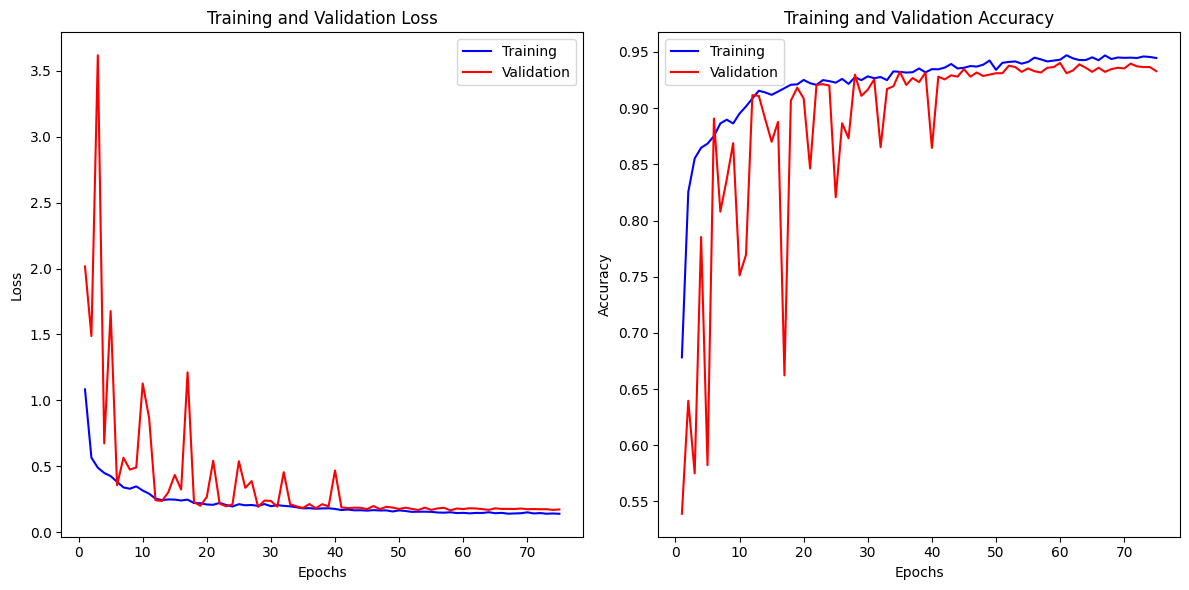

In [ ]:
# Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training')
plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accucracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training')
plt.plot(epochs, val_accuracy, 'r-', label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
evaluation = resnet_model.evaluate(
    test_generator,  
    steps=len(test_generator),
    verbose=1
)
print(f"Test Loss: {evaluation[0]:.4f}, Test Accuracy: {evaluation[1]:.4f}")

65/65 [==============================] - 10s 151ms/step - loss: 0.2038 - accuracy: 0.9224
Test Loss: 0.2038, Test Accuracy: 0.9224


In [106]:
# resnet_model.save('resnet.keras')
resnet_model.save('resnet_model.h5')